In [8]:
import xarray as xr
import random
import datetime
import numpy as np

In [17]:
longitude = np.arange(0, 360, 50.5)
latitude = np.arange(-90, 90, 50.5)
time = np.array(
    [
        datetime.date(1950, 1, 1),
        datetime.date(1951, 1, 1),
        datetime.date(1979, 1, 1),
        datetime.date(2022, 1, 1),
    ]
).astype("datetime64[ns]")
climatic_data = np.random.uniform(
            -10, 130, (len(longitude), len(latitude), len(time))
        )
data = xr.Dataset(
            {'pei_180': (["longitude", "latitude", "time"], climatic_data)},
            coords={"longitude": longitude, "latitude": latitude, "time": time},
        )
data.longitude.values

array([  0. ,  50.5, 101. , 151.5, 202. , 252.5, 303. , 353.5])

In [20]:
data.roll(longitude=180 * 4, roll_coords=True)
data #.longitude.values

<xarray.Dataset> Size: 1kB
Dimensions:    (longitude: 8, latitude: 4, time: 4)
Coordinates:
  * longitude  (longitude) float64 64B 0.0 50.5 101.0 ... 252.5 303.0 353.5
  * latitude   (latitude) float64 32B -90.0 -39.5 11.0 61.5
  * time       (time) datetime64[ns] 32B 1950-01-01 1951-01-01 ... 2022-01-01
Data variables:
    pei_180    (longitude, latitude, time) float64 1kB 85.73 16.67 ... 87.87

In [20]:
ds = xr.open_zarr("/Net/Groups/BGI/work_1/scratch/fluxcom/upscaling_inputs/MODIS_VI_perRegion061/EVI/Groups_EVIgapfilled_QCdyn.zarr")

/tmp/ipykernel_270661/3789137383.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr("/Net/Groups/BGI/work_1/scratch/fluxcom/upscaling_inputs/MODIS_VI_perRegion061/EVI/Groups_EVIgapfilled_QCdyn.zarr")


In [22]:
ds_vi = ds.EVIgapfilled_QCdyn.stack({'lat':['latchunk','latstep_modis'], 'lon':['lonchunk','lonstep_modis']})
# Load the dataset
lat_indices = random.choices(ds_vi.lat.values, k=3000)
lon_indices = random.choices(ds_vi.lon.values, k=3000)
ds_vi.isel(time=1).values

(array([3.0900000e+02, 1.4270000e+03, 1.4253637e+07, 1.6617208e+07,
        4.3680760e+06, 1.7998000e+04, 5.1000000e+01, 5.8000000e+01,
        7.1000000e+01, 1.6200000e+02]),
 array([-0.76004606, -0.45912984, -0.15821362,  0.14270261,  0.44361883,
         0.74453509,  1.04545128,  1.34636748,  1.64728379,  1.94819999,
         2.24911618]),
 <BarContainer object of 10 artists>)

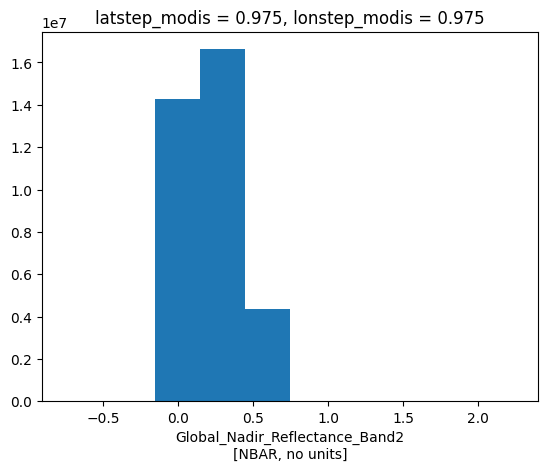

In [23]:
ds_vi.sel(latstep_modis=50.0, lonstep_modis=11, method='nearest').plot()

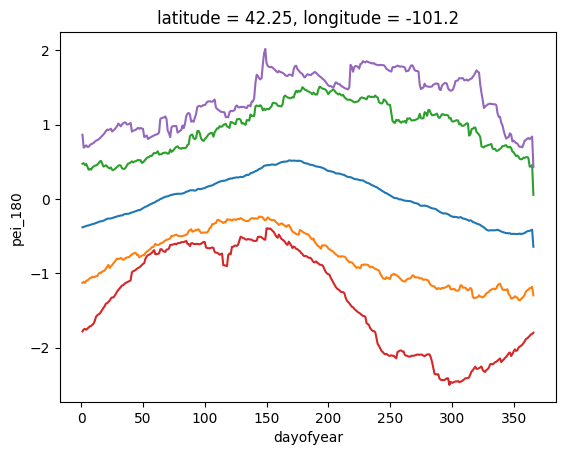

In [3]:
#select a location 
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr")

# Transform the longitude coordinates to -180 and 180
def coordstolongitude(x):
       return ((x + 180) % 360) - 180
dsc = ds.roll(longitude = 180*4, roll_coords=True)
ds_pei = dsc.assign_coords(longitude = coordstolongitude(dsc.longitude))
# Remove the year 1950 because the data are inconsistent
ds_pei = ds_pei.sel(time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31)))

lat_indices = random.choices(ds_pei.latitude.values, k=1000)
lon_indices = random.choices(ds_pei.longitude.values, k=1000)
pei = ds_pei.sel(latitude=lat_indices[500], longitude=lon_indices[500], time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31))).pei_180

# plot the seasonality
pei.groupby("time.dayofyear").mean("time").plot(label='mean')
pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.05, dim="time").plot()
pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.95, dim="time").plot()
pei.groupby("time.dayofyear").min("time").plot()
pei.groupby("time.dayofyear").max("time").plot()


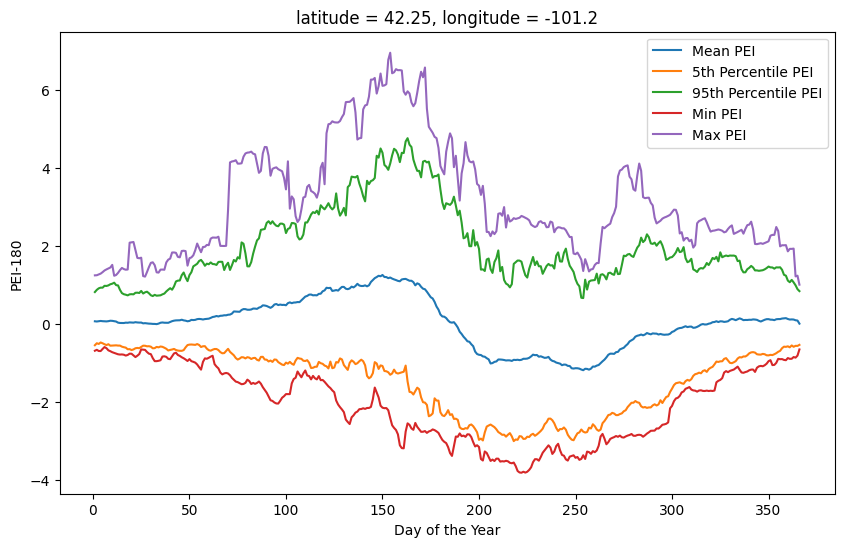

In [19]:
import matplotlib.pyplot as plt
import xarray as xr

pei = ds_pei.sel(latitude=lat_indices[500], longitude=lon_indices[500], time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31))).pei_30

# Group by day of the year and calculate required statistics
mean_pei = pei.groupby("time.dayofyear").mean("time")
quantile_05_pei = pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.05, dim="time")
quantile_95_pei = pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.95, dim="time")
min_pei = pei.groupby("time.dayofyear").min("time")
max_pei = pei.groupby("time.dayofyear").max("time")

# Plot the results
plt.figure(figsize=(10, 6))
mean_pei.plot(label='Mean PEI')
quantile_05_pei.plot(label='5th Percentile PEI')
quantile_95_pei.plot(label='95th Percentile PEI')
min_pei.plot(label='Min PEI')
max_pei.plot(label='Max PEI')

# Add labels and title
plt.xlabel('Day of the Year')
plt.ylabel('PEI-180')
#plt.title('PEI Statistics by Day of the Year')
plt.legend()
plt.show()


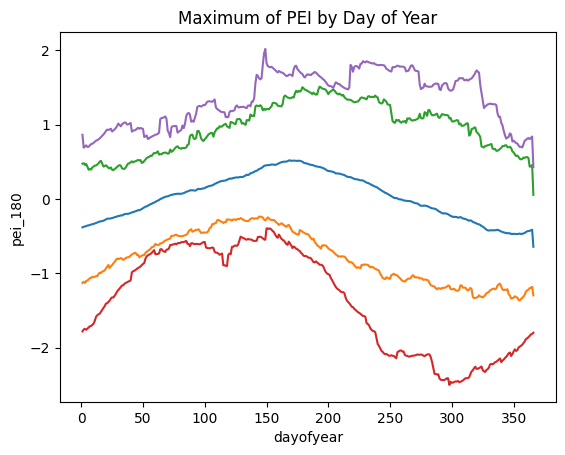

In [8]:
import matplotlib.pyplot as plt
import xarray as xr

# Assuming `pei` is your dataset loaded as an xarray DataArray or Dataset

# Group by day of the year and calculate required statistics
mean_pei = pei.groupby("time.dayofyear").mean("time")
quantile_05_pei = pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.05, dim="time")
quantile_95_pei = pei.chunk(dict(time=-1)).groupby("time.dayofyear").quantile(q=0.95, dim="time")
min_pei = pei.groupby("time.dayofyear").min("time")
max_pei = pei.groupby("time.dayofyear").max("time")

# Plot each statistic with a title
mean_pei.plot()
plt.title('Mean of PEI by Day of Year')

quantile_05_pei.plot()
plt.title('5th Percentile of PEI by Day of Year')

quantile_95_pei.plot()
plt.title('95th Percentile of PEI by Day of Year')

min_pei.plot()
plt.title('Minimum of PEI by Day of Year')

max_pei.plot()
plt.title('Maximum of PEI by Day of Year')

plt.show()

In [3]:
# Load the PEI-* drought indices
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr")

# Transform the longitude coordinates to -180 and 180
def coordstolongitude(x):
       return ((x + 180) % 360) - 180
dsc = ds.roll(longitude = 180*4, roll_coords=True)
ds_pei = dsc.assign_coords(longitude = coordstolongitude(dsc.longitude))
# Remove the year 1950 because the data are inconsistent
ds_pei = ds_pei.sel(time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31)))

# Stack the longitude and latitude dimensions into a new dimension called lonlat
ds_pei = ds_pei.stack(lonlat=("longitude", "latitude")).transpose(
            "lonlat", "time", ...
        )

# Remove the year 1950 because the data are inconsistent
ds_pei = ds_pei.sel(
            time=slice(datetime.date(1951, 1, 1), datetime.date(2022, 12, 31))
        )

# Select k locations randomly to train the PCA:
lat_indices = random.choices(ds_pei.latitude.values, k=10)
lon_indices = random.choices(ds_pei.longitude.values, k=10)
ds_pei = ds_pei.sel(latitude=lat_indices, longitude=lon_indices)

# Stack the longitude and latitude dimensions into a new dimension called lonlat
ds_pei = ds_pei.stack(lonlat=('longitude', 'latitude')).transpose('lonlat', 'time', ...)

# compute the MSC
for pei_indice in ['pei_30', 'pei_90', 'pei_180']:
    ds_pei[f'msc_{pei_indice}'] = ds_pei[pei_indice].groupby("time.dayofyear").mean("time")

In [2]:
# Load the PEI-* drought indices
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr", )


In [2]:
# Load the PEI-* drought indices
ds = xr.open_zarr("/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr", )

# Transform the longitude coordinates to -180 and 180
def coordstolongitude(x):
       return ((x + 180) % 360) - 180
dsc = ds.roll(longitude = 180*4, roll_coords=True)
#ds_pei = dsc.assign_coords(longitude = coordstolongitude(dsc.longitude))
# Remove the year 1950 because the data are inconsistent
# ds_pei = ds_pei.sel(time=slice(datetime.date(1951,1,1), datetime.date(2022,12,31)))

# Stack the longitude and latitude dimensions into a new dimension called lonlat
#ds_pei = ds_pei.stack(lonlat=("longitude", "latitude")).transpose(
#            "lonlat", "time", ...
#        )
# ds_pei

In [18]:
for i in ds_pei.data_vars:
    print(i)

pei_180
pei_30
pei_90
msc_pei_30
msc_pei_90
msc_pei_180


PCA(n_components=10)

In [88]:
pca.explained_variance_ratio_[:5]

array([0.63044574, 0.28205099, 0.03906764, 0.02449689, 0.01613243])

<BarContainer object of 73 artists>

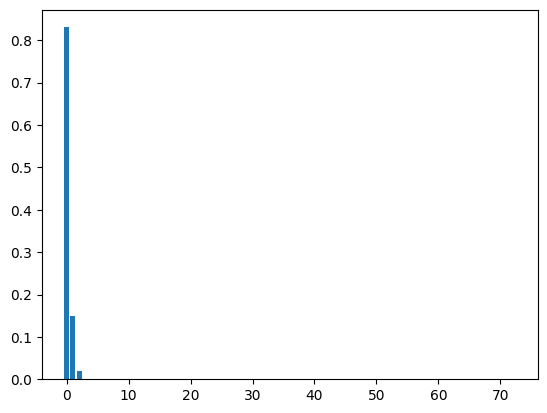

In [63]:
import matplotlib.pyplot as plt
plt.bar(range(n_components), pca.explained_variance_ratio_)

In [ ]:
# Add the project root to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

# from regional_extremes import CLIMATIC_FILEPATH
CLIMATIC_FILEPATH = "/Net/Groups/BGI/scratch/mweynants/DeepExtremes/v3/PEICube.zarr"
from regional_extremes import RegionalExtremes, ClimaticRegionalExtremes